# electrical preprocessing experiments

In [1]:
import numpy as np
from scipy.signal import butter, lfilter, medfilt, savgol_filter, welch, hilbert
from scipy.fft import fft
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
path = "/its/home/drs25/RoboSkin/Code/NewRigExperiments/"
datapath=path+"texture-tactip/"
datapath="/its/home/drs25/datasets/"


#windows
path="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/"
datapath="C:/Users/dexte/gitHub/RoboSkin/Code/NewRigExperiments/electrical-tactile-sensor/"

## load in dataset

In [4]:
data = np.load(datapath+"X_data_presstip.npz") #load data
X=None
for array_name in data:
    X=data[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data = np.load(datapath+"y_data_presstip.npz") #load data
y=None
for array_name in data:
    y=data[array_name]
print(X.shape,y.shape)

(3000, 20, 16) (3000,)


## preprocess functions

In [5]:
def butterworth_filter(data, cutoff=8, fs=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return np.array([lfilter(b, a, d) for d in data])

def low_pass_filter(data, cutoff=8, fs=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return np.array([lfilter(b, a, d) for d in data])

def median_filter(data, kernel_size=5):
    return np.array([medfilt(d, kernel_size=kernel_size) for d in data])

def savgol_filter_data(data, window_length=11, polyorder=3):
    return np.array([savgol_filter(d, window_length=window_length, polyorder=polyorder) for d in data])

def apply_fft(data):
    return np.abs(fft(data))[:, :data.shape[1] // 2]

def compute_psd(data, fs=50):
    return np.array([welch(d, fs=fs, nperseg=min(64, len(d)))[1] for d in data])

def wavelet_transform(data, wavelet='db4', level=3):
    return np.array([pywt.wavedec(d, wavelet, level=level)[0] for d in data])

def hilbert_transform(data):
    return np.abs(hilbert(data, axis=-1))

def none(data):
    return data

c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


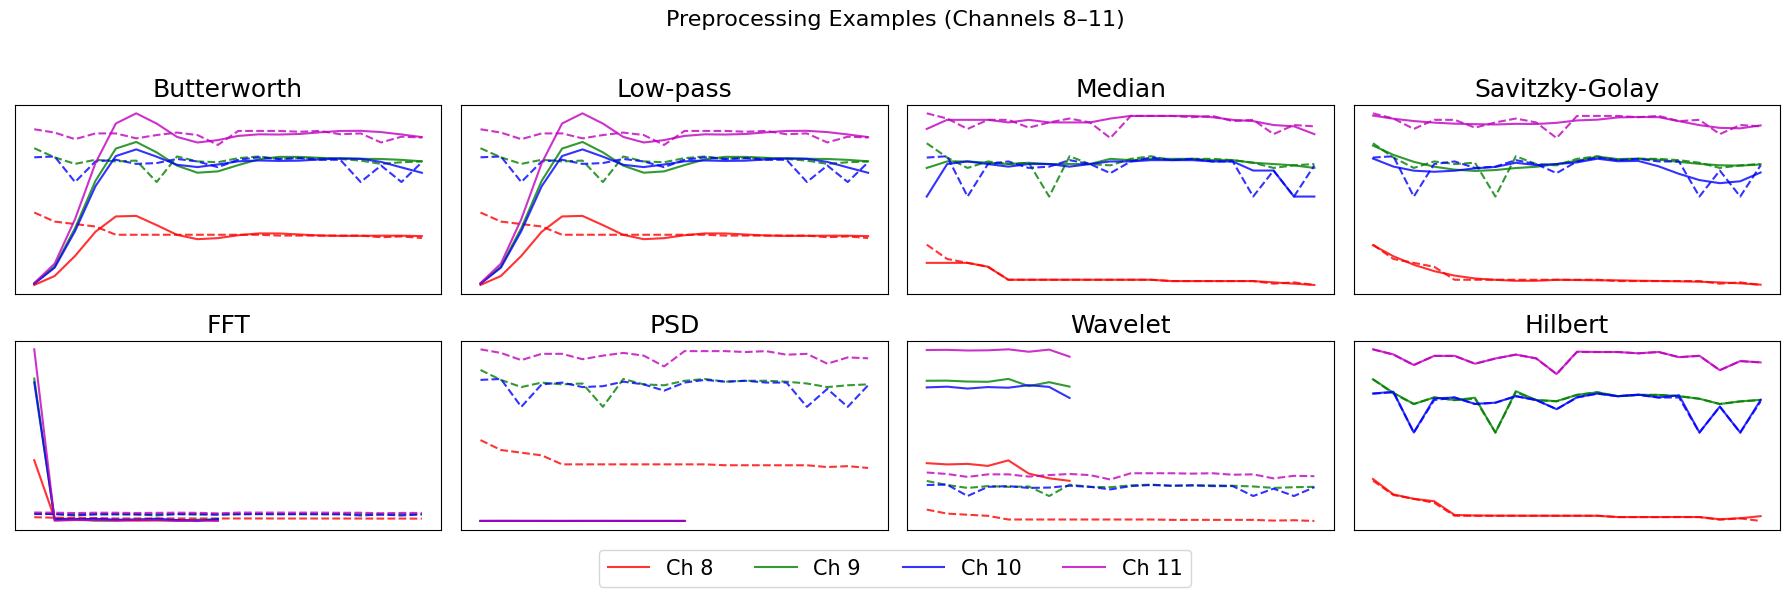

In [6]:
channels=[8,9,10,11]
fs=50
signals = np.array([X[0, :, ch] for ch in channels])  # shape (4, T)
methods = [
    ("Butterworth", butterworth_filter(signals, 8,fs=fs)),
    ("Low-pass", low_pass_filter(signals, 8, fs=fs)),
    ("Median", median_filter(signals)),
    ("Savitzky-Golay", savgol_filter_data(signals)),
    ("FFT", apply_fft(signals)),
    ("PSD", compute_psd(signals, fs=fs)),
    ("Wavelet", wavelet_transform(signals)),
    ("Hilbert", hilbert_transform(signals)),
]

# Plotting: 2x4 layout
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
fig.suptitle('Preprocessing Examples (Channels 8–11)', fontsize=16)
c = ["r", "g", "b", "m"]

# Store lines to use for the legend
lines = []
labels = []

for ax, (title, processed) in zip(axes.flatten(), methods):
    for i, ch in enumerate(channels):
        l1, = ax.plot(processed[i], c=c[i], label=f"Ch {ch}", alpha=0.8)
        l2, = ax.plot(signals[i], "--", c=c[i], label=f"Ch {ch}", alpha=0.8)
        if len(lines) < len(channels):  # Add each label once
            lines.append(l1)
            labels.append(f"Ch {ch}")
    ax.set_title(title, fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

# Add a single horizontal legend below all subplots
fig.legend(lines, labels, loc="lower center", fontsize=15, ncol=len(channels))

plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Leave space at bottom for legend
plt.savefig(path + "/images/preprocessing_example.pdf")
plt.show()

In [7]:
#signals = np.array([X[0, :, ch] for ch in channels])  # shape (4, T)
channels=[8,9,10,11]
print(X[i, :, ch].reshape(1,len(X[0])).shape)

"""methods = [[[butterworth_filter(X[i, :, ch].reshape((1,len(X[0]),1)), 8,fs=fs),low_pass_filter(X[i, :, ch].reshape((1,len(X[0]),1)), 8, fs=fs),
    median_filter(X[i, :, ch]),savgol_filter_data(X[i, :, ch].reshape((1,len(X[0])))),
    apply_fft(X[i, :, ch]).reshape((1,len(X[0]),1)),compute_psd(X[i, :, ch], fs=fs).reshape((1,len(X[0]),1)),
    wavelet_transform(X[i, :, ch]).reshape((1,len(X[0]),1)), hilbert_transform(X[i, :, ch] ).reshape((1,len(X[0]),1)),
] for ch in channels] for i in range(len(X))]"""

signals = np.array([[X[i, :, ch] for i in range(len(X))] for ch in channels]).reshape(4*len(X),20)  # shape (4, T)
print(signals.shape)
methods = {
    "Butterworth": butterworth_filter(signals, 8,fs=fs).reshape(4,len(X),20),
    "Low-pass": low_pass_filter(signals, 8, fs=fs).reshape(4,len(X),20),
    "Median": median_filter(signals).reshape(4,len(X),20),
    "Savitzky-Golay": savgol_filter_data(signals).reshape(4,len(X),20),
    "FFT": apply_fft(signals).reshape(4,len(X),-1),
    "PSD": compute_psd(signals, fs=fs).reshape(4,len(X),-1),
    "Wavelet": wavelet_transform(signals).reshape(4,len(X),-1),
    "Hilbert": hilbert_transform(signals).reshape(4,len(X),20),
    "None": none(signals).reshape(4,len(X),20),
}


(1, 20)
(12000, 20)


c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


# experiment with models

In [8]:
butterworth_X=methods['Butterworth']

def model_test(dataset):
    train_X, test_X, train_y, test_y = train_test_split(dataset.reshape(len(dataset),-1), y, test_size=0.2, random_state=np.random.randint(0,100))
    print(train_X.shape)
    clf = RandomForestClassifier(max_depth=50, random_state=0)
    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    y_pred2 = clf.predict(train_X)

    loss=np.abs(y_pred-test_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    print("Test Accuracy:",correct/len(loss))
    tt=correct/len(loss)
    loss=np.abs(y_pred2-train_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    print("Train Accuracy:",correct/len(loss))
    return tt, correct/len(loss)



In [ ]:
method_results={}
keys=list(methods.keys())
for key in keys:
    function_data=methods[key]
    print(function_data.shape)
    method_results[key]=np.zeros((40,3,2))
    for i in range(40):
        test,train=model_test(function_data[0]) #piezoe
        method_results[key][i][0]=[test,train]
        acc=np.concatenate([function_data[1].T,function_data[2].T,function_data[3].T]).T
        test,train=model_test(acc) #accelerometer
        method_results[key][i][1]=[test,train]
        all_=np.concatenate([function_data[0].T,function_data[1].T,function_data[2].T,function_data[3].T]).T
        test,train=model_test(all_) #both
        method_results[key][i][2]=[test,train]
    

In [96]:
method_results['None']=np.zeros((40,3,2))
for i in range(40):
    test,train=model_test(function_data[0]) #piezoe
    method_results['None'][i][0]=[test,train]
    acc=np.concatenate([function_data[1].T,function_data[2].T,function_data[3].T]).T
    test,train=model_test(acc) #accelerometer
    method_results['None'][i][1]=[test,train]
    all_=np.concatenate([function_data[0].T,function_data[1].T,function_data[2].T,function_data[3].T]).T
    test,train=model_test(all_) #both
    method_results['None'][i][2]=[test,train]

(2400, 20)
Test Accuracy: 0.7716666666666666
Train Accuracy: 1.0
(2400, 60)
Test Accuracy: 0.66
Train Accuracy: 1.0
(2400, 80)
Test Accuracy: 0.89
Train Accuracy: 1.0
(2400, 20)
Test Accuracy: 0.8
Train Accuracy: 1.0
(2400, 60)
Test Accuracy: 0.6566666666666666
Train Accuracy: 1.0
(2400, 80)
Test Accuracy: 0.865
Train Accuracy: 1.0
(2400, 20)
Test Accuracy: 0.7716666666666666
Train Accuracy: 1.0
(2400, 60)
Test Accuracy: 0.585
Train Accuracy: 1.0
(2400, 80)
Test Accuracy: 0.8883333333333333
Train Accuracy: 1.0
(2400, 20)
Test Accuracy: 0.7616666666666667
Train Accuracy: 1.0
(2400, 60)
Test Accuracy: 0.625
Train Accuracy: 1.0
(2400, 80)
Test Accuracy: 0.8766666666666667
Train Accuracy: 1.0
(2400, 20)
Test Accuracy: 0.79
Train Accuracy: 1.0
(2400, 60)
Test Accuracy: 0.675
Train Accuracy: 1.0
(2400, 80)
Test Accuracy: 0.8816666666666667
Train Accuracy: 1.0
(2400, 20)
Test Accuracy: 0.7933333333333333
Train Accuracy: 1.0
(2400, 60)
Test Accuracy: 0.68
Train Accuracy: 1.0
(2400, 80)
Test Ac

### display results

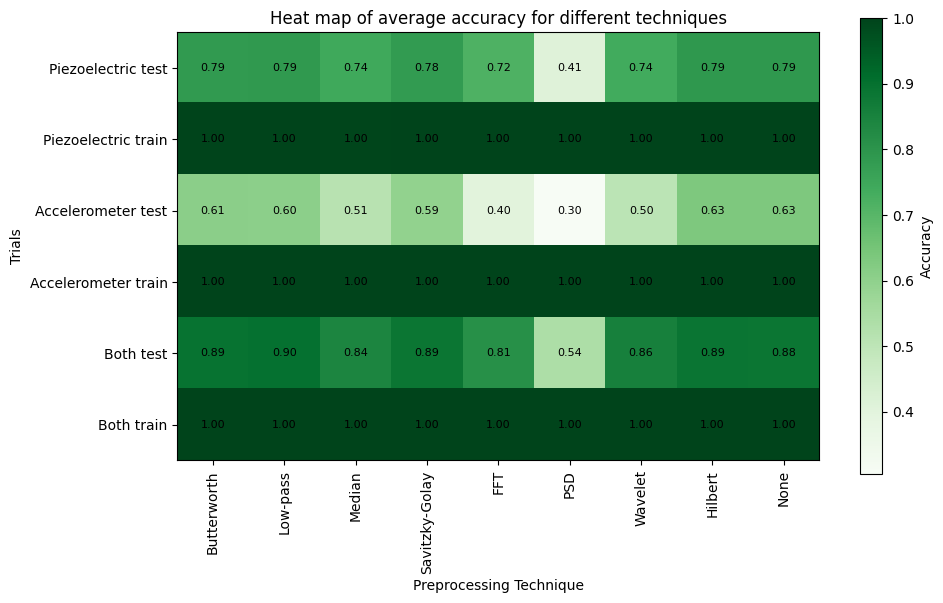

In [104]:
keys=list(method_results.keys())
image=np.zeros((len(keys),6))
labels=["Piezoelectric test","Piezoelectric train","Accelerometer test","Accelerometer train","Both test","Both train"]
test_best_=[]
for i in range(len(keys)):
    data1=np.average(method_results[keys[i]][:,0],axis=0)
    data2=np.average(method_results[keys[i]][:,1],axis=0)
    data3=np.average(method_results[keys[i]][:,2],axis=0)
    line=np.concatenate([data1,data2,data3])
    image[i]=line
    test_best_.append(method_results[keys[i]][:,2])
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(image.T, cmap="Greens")

# Set ticks and labels
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels(keys, rotation=90)
ax.set_xlabel("Preprocessing Technique")
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_ylabel("Trials")
ax.set_title("Heat map of average accuracy for different techniques")

# Add color bar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("Accuracy")

# Annotate each cell with its value
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        value = image[i, j]
        ax.text(i, j, f"{value:.2f}", ha="center", va="center", fontsize=8, color="black")

plt.tight_layout()
plt.savefig(path+"/images/heatmap_preprocess.pdf")
plt.show()

### test signficance

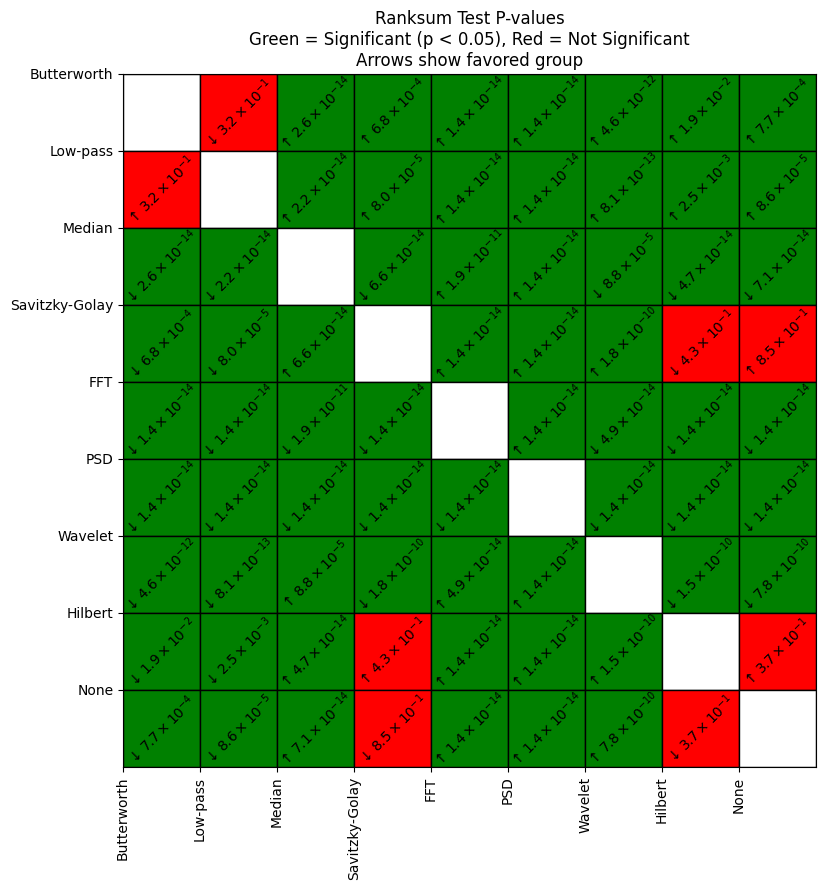

In [116]:
import numpy as np
from scipy.stats import ranksums
import matplotlib.pyplot as plt

# Assuming test_best_ is your data of shape (9, 40, 1)
test_best = np.array(test_best_)[:, :, 0]

# Compute p-value and direction matrix
p_matrix = np.zeros((9, 9))
direction_matrix = np.empty((9, 9), dtype=str)

for i in range(9):
    for j in range(9):
        if i == j:
            p_matrix[i, j] = np.nan
            direction_matrix[i, j] = ""
        else:
            stat, p = ranksums(test_best[i], test_best[j])
            p_matrix[i, j] = p
            if stat > 0:
                direction_matrix[i, j] = "↑"  # x-axis group is higher
            elif stat < 0:
                direction_matrix[i, j] = "↓"  # y-axis group is higher
            else:
                direction_matrix[i, j] = "→"  # very rare case of identical ranks

# Plot setup
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_xticks(np.arange(9))
ax.set_yticks(np.arange(9))
ax.set_xticklabels([keys[i] for i in range(9)], rotation=90)
ax.set_yticklabels([keys[i] for i in range(9)])
ax.set_title("Ranksum Test P-values\nGreen = Significant (p < 0.05), Red = Not Significant\nArrows show favored group")

# Draw grid and text
for i in range(9):
    for j in range(9):
        p = p_matrix[i, j]
        direction = direction_matrix[i, j]
        if np.isnan(p):
            color = 'white'
            text = ""
        elif p < 0.05:
            color = 'green'
            base = f"{p:.1e}".split("e")
            text = rf"{direction} ${base[0]}\times 10^{{{int(base[1])}}}$"
        else:
            color = 'red'
            base = f"{p:.1e}".split("e")
            text = rf"{direction} ${base[0]}\times 10^{{{int(base[1])}}}$"

        rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        if text:
            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=10, rotation=45)

# Aesthetic adjustments
ax.set_xlim(0, 9)
ax.set_ylim(0, 9)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(path+"/images/heatmap_significance_elec.pdf")
plt.show()


# t frames

In [10]:
results=np.zeros((len(range(0,20)),len(range(0,20)),40,2))
function_data=methods['Butterworth']
for t_start in range(0,20):
    for t_end in range(1,20):
        if t_start<t_end:
            for i in range(20):
                print(t_start,t_end)
                all_=np.concatenate([function_data[0,:,t_start:t_end].T,function_data[1,:,t_start:t_end].T,function_data[2,:,t_start:t_end].T,function_data[3,:,t_start:t_end].T]).T
                print(all_.shape)
                test,train=model_test(all_) #both
                results[t_start][t_end][i]=[test,train]
    
            np.save(path+"/data/results_of_t_for_both_presstip_RFC",results)

0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.7266666666666667
Train Accuracy: 0.9733333333333334
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.705
Train Accuracy: 0.9754166666666667
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.705
Train Accuracy: 0.97625
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.71
Train Accuracy: 0.97375
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.6833333333333333
Train Accuracy: 0.9783333333333334
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.7033333333333334
Train Accuracy: 0.9725
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.675
Train Accuracy: 0.9741666666666666
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.7383333333333333
Train Accuracy: 0.9741666666666666
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.7033333333333334
Train Accuracy: 0.9758333333333333
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.705
Train Accuracy: 0.97625
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.69
Train Accuracy: 0.975
0 1
(3000, 4)
(2400, 4)
Test Accuracy: 0.695
Train Accuracy: 0.9745833333333334
0 1
(3000, 4)
(2400, 4)
Test Accura

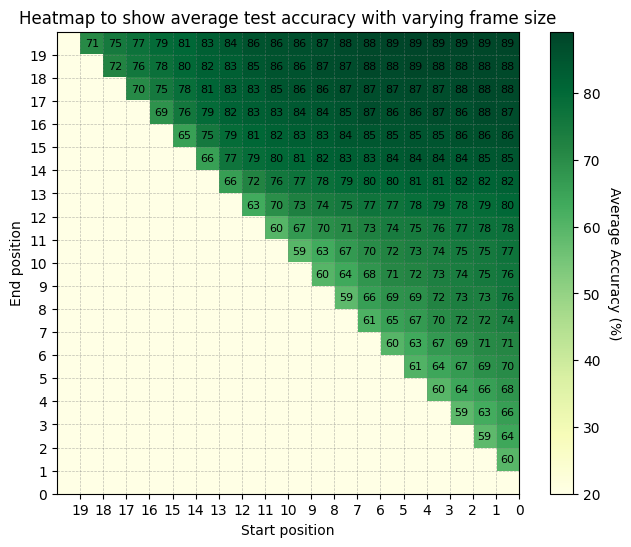

In [32]:
#results=np.load(path+"/data/results_of_t_for_both_presstip_RFC.npy")

av = np.average(results[:,:,:20,0], axis=2)*100
av[:, :][av==0]=20
plt.figure(figsize=(8, 6))
im = plt.imshow(av[:, :], cmap="YlGn")

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label("Average Accuracy (%)", rotation=270, labelpad=15)  # rotate label and add padding


# Set axis labels
plt.xlabel("Start position")
plt.ylabel("End position")
plt.title("Heatmap to show average test accuracy with varying frame size")

# Adjust ticks to center of cells (offset by 0.5)
xticks = np.arange(av.shape[1])
yticks = np.arange(av.shape[0])
plt.xticks(ticks=xticks + 0.5, labels=reversed(xticks))
plt.yticks(ticks=yticks + 0.5, labels=reversed(yticks))

# Add grid
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Annotate each cell with the value, rounded to 2 decimal places
for i in range(av.shape[0]):
    for j in range(av.shape[1]):
        value = int(round(av[j, i], 0))
        if value!=20:
            plt.text(i, j, str(value), ha='center', va='center', color='black', fontsize=8)

# Save and show plot
plt.savefig(path + "/images/temporal_heatmap_elec.pdf")
plt.show()

array([[0.89166667, 1.        ],
       [0.885     , 1.        ],
       [0.90833333, 1.        ],
       [0.875     , 1.        ],
       [0.85166667, 1.        ],
       [0.86333333, 1.        ],
       [0.87333333, 1.        ],
       [0.89333333, 1.        ],
       [0.865     , 1.        ],
       [0.88166667, 1.        ],
       [0.88666667, 1.        ],
       [0.88333333, 1.        ],
       [0.86      , 1.        ],
       [0.86166667, 1.        ],
       [0.89      , 1.        ],
       [0.85166667, 1.        ],
       [0.88666667, 1.        ],
       [0.88833333, 1.        ],
       [0.91333333, 1.        ],
       [0.89      , 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.